In [1]:
!which python3

/tikhome/msauter/miniconda3/envs/znnl-gpu/bin/python3


In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import znnl as nl
from flax import linen as nn
import optax

2024-02-29 14:40:08.477377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 14:40:08.477403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 14:40:08.478294: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 14:40:11.038279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-29 14:40:17.394155: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disa

Using backend: gpu

Available hardware:

cuda:0

# Setup Experiment

In [2]:
class Architecture(nn.Module):
    """
    Dense Archtecture
    """
    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

In [50]:
#Training runner
def run_training(Loss, Lossname, Epochs, Dataset_size):
    # Making a data generator
    data_generator = nl.data.MNISTGenerator(Dataset_size)
    
    #Defining the network
    flax_model = nl.models.FlaxModel(
        flax_module = Architecture(),
        input_shape = (1,28,28,1),
        optimizer = optax.sgd(5e-2),
        batch_size=50,
    )
    
    #Define recorders for loss ntk and ntk

    r_train_recorder = nl.training_recording.JaxRecorder(
        name=f"r_train_recorder_{Lossname}",
        loss=True,
        accuracy=True,
        entropy=True,
        eigenvalues=True,
        trace=True,
        covariance_entropy=True,
        magnitude_variance=True,

        use_loss_ntk = False,

        update_rate=1, 
        chunk_size=100
        )

    l_train_recorder = nl.training_recording.JaxRecorder(
        name=f"l_train_recorder_{Lossname}",
        loss=True,
        accuracy=True,
        entropy=True,
        eigenvalues=True,
        trace=True,
        covariance_entropy=True,
        magnitude_variance=True,

        use_loss_ntk = True,

        update_rate=1, 
        chunk_size=100
        )

    test_recorder = nl.training_recording.JaxRecorder(
        name=f"test_recorder_{Lossname}",
        loss=True,
        accuracy=True,
        update_rate=1,
        chunk_size=100,
    )

    r_train_recorder.instantiate_recorder(data_set = data_generator.train_ds)
    l_train_recorder.instantiate_recorder(data_set = data_generator.train_ds)
    test_recorder.instantiate_recorder(data_set = data_generator.test_ds)

    training_strategy = nl.training_strategies.SimpleTraining(
        model=flax_model,
        loss_fn=Loss,
        recorders=[r_train_recorder,l_train_recorder,test_recorder],
        accuracy_fn=nl.accuracy_functions.LabelAccuracy(),
    )
    
    #running the model for the wanted epochs
    batched_training_metrics = training_strategy.train_model(
        train_ds={"inputs": data_generator.train_ds["inputs"], "targets": data_generator.train_ds["targets"]},
        test_ds={"inputs": data_generator.test_ds["inputs"], "targets": data_generator.test_ds["targets"]},
        batch_size=100,
        epochs=Epochs,
    )
    
    #Dumping records
    r_train_recorder.dump_records()
    l_train_recorder.dump_records()
    test_recorder.dump_records()

# Run experiments

In [51]:
from znnl import loss_functions

losses = [loss_functions.CrossEntropyLoss(), loss_functions.LPNormLoss(order=2), loss_functions.MeanPowerLoss(order=4)]
lossnames = ["CrossEntropy", "LPNorm2", "MeanPowerLoss4"]

for i, loss in enumerate(losses):
    run_training(Loss = loss, 
                Lossname= lossnames[i],
                Epochs = 500,
                Dataset_size = 500)

  0%|                                                                    | 0/500 [00:00<?, ?batch/s]

# Analyze Experiments

In [40]:
#load data 
lossnames = ["CrossEntropy", "LPNorm2", "MeanPowerLoss4"]
recordernames = ["l_train_recorder_", "r_train_recorder_", "test_recorder_"]
recorders = dict()
reports = dict()

for lossname in lossnames:
    print("Loading "+lossname+"...")
    for recordername in recordernames:
        recorders[recordername+lossname] = nl.training_recording.DataStorage(recordername+lossname)
        if recordername[:4] == "test":
            reports[recordername+lossname] = recorders[recordername+lossname].fetch_data(["loss","accuracy"])
        else:
            reports[recordername+lossname] = recorders[recordername+lossname].fetch_data(["loss","accuracy","eigenvalues","entropy","covariance_entropy"])




Loading CrossEntropy...


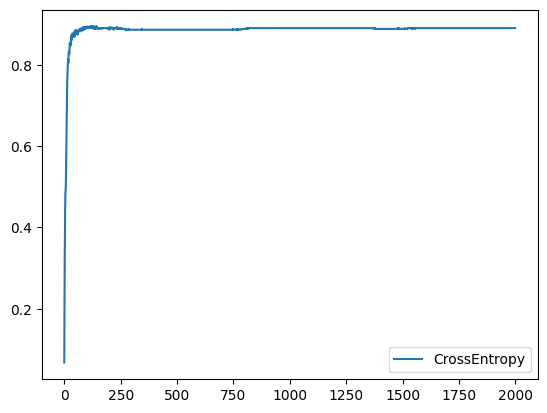

In [49]:
#Check that all models trained properly


import matplotlib.pyplot as plt
import numpy as np

for lossname in lossnames:
    plt.plot(reports["test_recorder_"+lossname]["accuracy"], label=lossname)
    #plt.yscale('log')
    plt.legend()
    plt.show()
